In [1]:
import numpy as np
import pandas as pd
import os
from random import randint
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm_notebook
import datetime
import torchvision.transforms as transforms
import warnings
import tensorflow
from tensorflow.keras.utils import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate
from tensorflow import keras
sns.set_style("white")
plt.style.use('seaborn-white')
warnings.filterwarnings('ignore')
transformGray = transforms.Grayscale()  

In [2]:
# Defining the directories to find the data we will need (online directories). You can always change these to run locally with a different directory structure.
TRAIN_IMAGE_DIR = 'competition_data/train/images/'
TRAIN_MASK_DIR = 'competition_data/train/masks/'
MAIN_DIR = 'competition_data/'

# Making a two-column data frame for the training data
train_df = pd.read_csv(MAIN_DIR + "train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(MAIN_DIR + "depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [3]:
length_train = len(train_df)
print("O numero de linhas no dataframe é ",length_train)

O numero de linhas no dataframe é  4000


In [4]:
train_img_list = sorted([os.path.join(TRAIN_IMAGE_DIR, f) for f in os.listdir(TRAIN_IMAGE_DIR) ])
mask_img_list = sorted([os.path.join(TRAIN_MASK_DIR, f) for f in os.listdir(TRAIN_MASK_DIR) ])

In [5]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [6]:
train_df["imgs"] = [np.array(transformGray(Image.open(TRAIN_IMAGE_DIR+"{}.png".format(idx)))) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["masks"] = [np.array(transformGray(Image.open(TRAIN_MASK_DIR+"{}.png".format(idx)))) / 255 for idx in tqdm_notebook(train_df.index)]

In [8]:
train_df["cobertura"] = train_df.masks.map(np.sum) / (img_size_ori*img_size_ori)

In [9]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["cobertura_class"] = train_df.cobertura.map(cov_to_class)

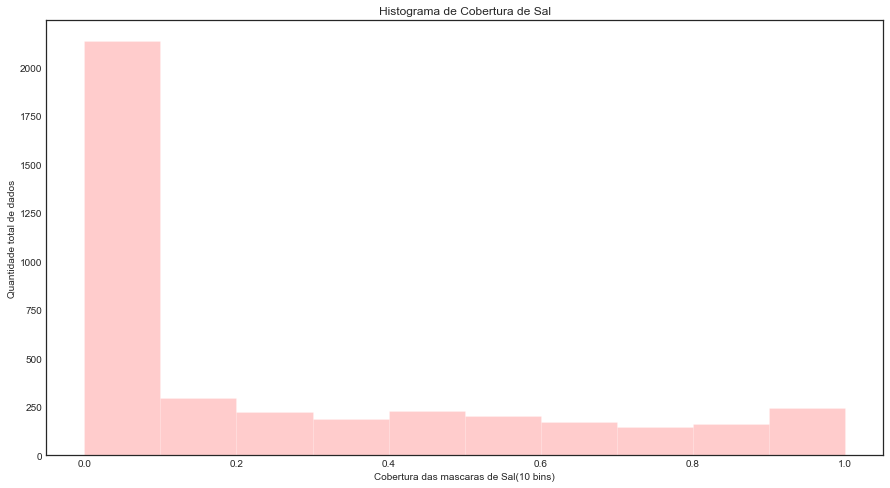

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
num_bins = 10
n, bins, patches = plt.hist(train_df.cobertura, num_bins, facecolor='red', alpha=0.2)
ax.set_xlabel('Cobertura das mascaras de Sal(10 bins)')
ax.set_ylabel('Quantidade total de dados')
ax.set_title(r'Histograma de Cobertura de Sal')
plt.savefig('CoberturaSal.png',bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Distribuição de profundidades')

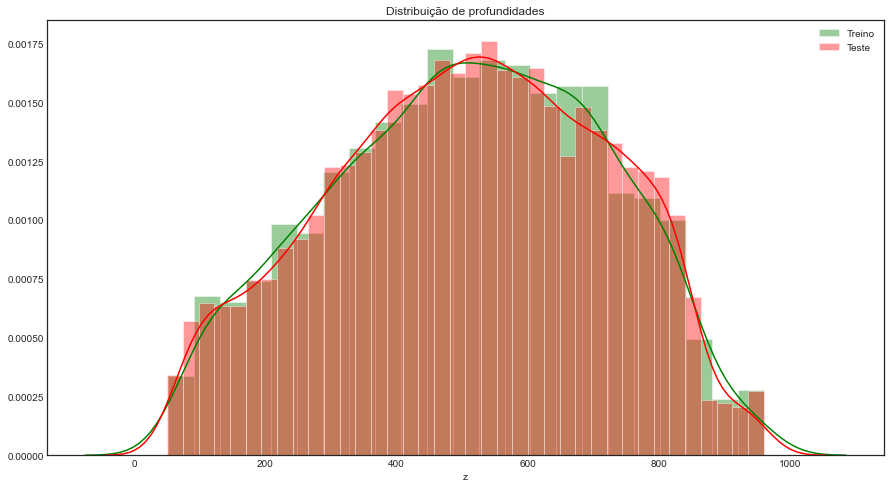

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
sns.distplot(train_df.z, label="Treino",color='green')
sns.distplot(test_df.z, label="Teste",color='red')
plt.legend()
plt.savefig('DistProfundidades.png',bbox_inches='tight')
plt.title("Distribuição de profundidades")

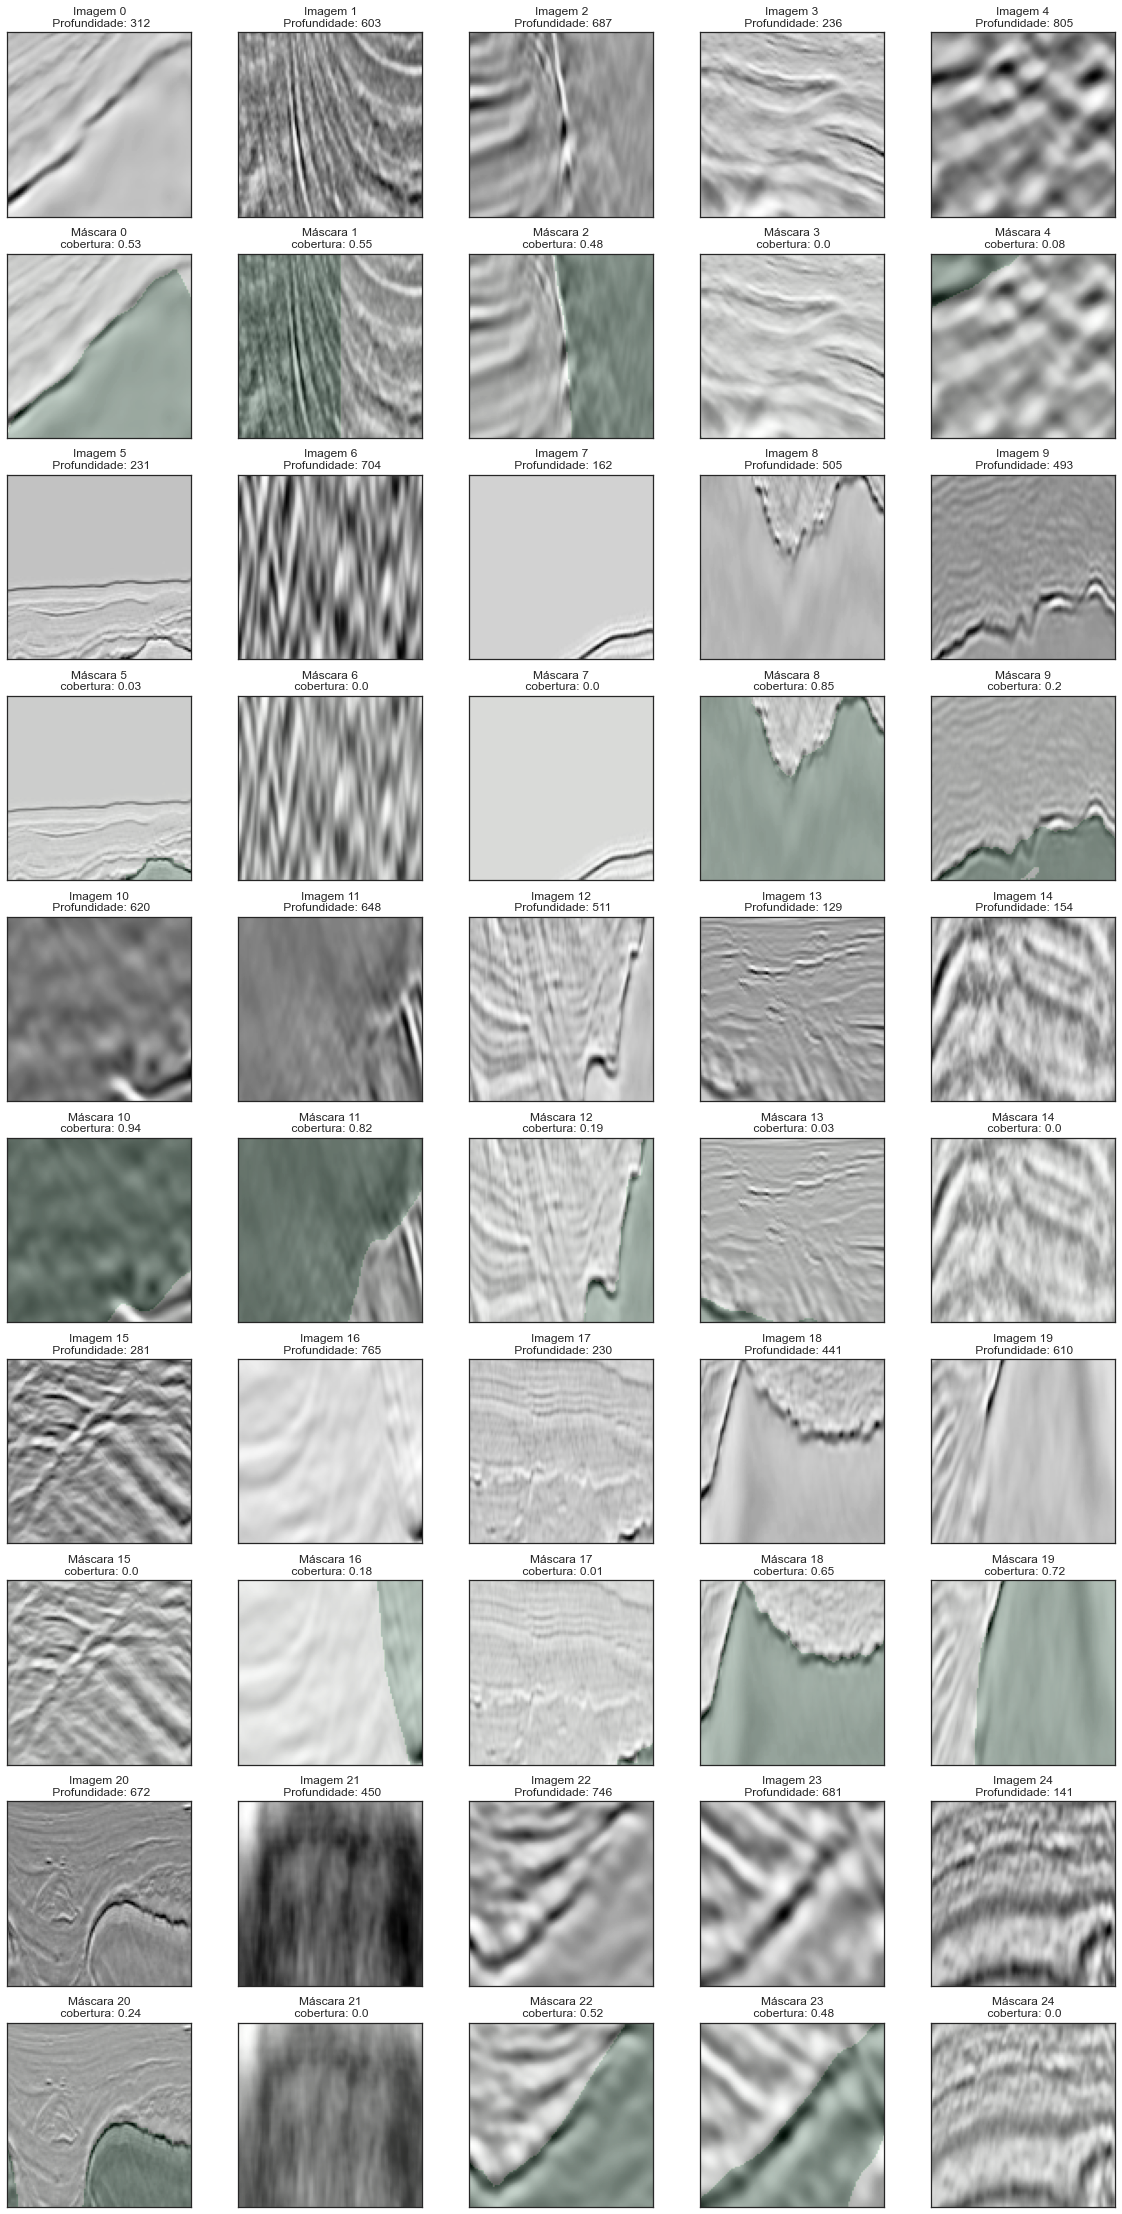

In [13]:
grid_lateral = 5
max_imgs = 25
grid_vertical = int(max_imgs / grid_lateral)*2

fig, axs = plt.subplots(grid_vertical, grid_lateral, figsize=(grid_lateral*4, grid_vertical*4))
for i, idx in enumerate(train_df.index[:max_imgs]):
    img = train_df.loc[idx].imgs
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_lateral)*2, i % grid_lateral]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Imagem {0}\n Profundidade: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_lateral)*2+1, i % grid_lateral]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Máscara {0}\n cobertura: {1}".format(i,  round(train_df.loc[idx].cobertura, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
plt.savefig('DatasetKaggle.png',bbox_inches='tight')

#### Utilizamos o train_test_split estratificado para dividir as amostras de treino e teste com base nas profundidades e nas profundidades

In [15]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.imgs.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.cobertura.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.cobertura_class, random_state=1337)

#### Agora vamos fazer o data augmentation com um flip horizontal dos pequenos pedaços de seções sísmicas:  

In [16]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

## Até aqui fizemos tudo em uma máquina local, depois disso salvamos os datasets de treino e validação divididos para utilizar no treinamento da rede no Google Colab

In [39]:
np.save("x_train.npy", x_train)
np.save("x_valid.npy", x_valid)
np.save("y_train.npy", y_train)
np.save("y_valid.npy", y_valid)

## No Google Colab criamos a rede, treinamos e rodamos. Isso nos poupou de instalar as blbiotecas e nos permitiu treinar em GPU, as do laboratório estavam ocupadas durante a semana.

#### O primeiro passo foi carregar os arquivos do Google drive no Colab

In [ ]:
dir_projeto = '/content/drive/MyDrive/projetoCausalidade/'

x_train=np.load(dir_projeto+"x_train.npy")
x_valid=np.load(dir_projeto+"x_valid.npy")
y_train=np.load(dir_projeto+"y_train.npy")
y_valid=np.load(dir_projeto+"y_valid.npy")

### Definindo os blocos do modelo :

In [ ]:
def build_model(input_layer, start_neurons):

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)


    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    ucov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer
img_size_ori = 101
img_size_target = 128
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

### Criando uma instância do modelo:

In [ ]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)

#### Definindo o ótimozador e a loss do modelo

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Visualizando a instância do modelo

In [ ]:
model.summary()

#### Salvando a primeira instância do modelo

In [ ]:
model.save(path)

#### Treinando o modelo

In [ ]:
# Caso já tenha uma versao-pretreinada, carregue
path=dir_projeto+'UNET.keras'
if os.path.exists(path):
  model = keras.models.load_model(path)

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

epochs = 100
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])
model.save(path)

### Fazendo as predições do modelo nos dados de treino

In [ ]:
preds_train = model.predict(x_train).reshape(-1, img_size_target, img_size_target)
preds_train = np.array([downsample(x) for x in preds_train])

### Fazendo as predições do modelo nos dados de teste/validação

In [ ]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])

## Salvando as predições para fazermos as análises dos resultados localmente:

In [ ]:
np.save(dir_projeto+"preds_train.npy", preds_train)
np.save(dir_projeto+"preds_train.npy", preds_train)
np.save(dir_projeto+"preds_train.npy", preds_train)
np.save(dir_projeto+"preds_train.npy", preds_train)
np.save(dir_projeto+"preds_train.npy", preds_train)
np.save(dir_projeto+"mask_train.npy", mask_train)

## A partir daqui carregamos, os dados treinados do Google Colab e seguimos localmente.

In [18]:
pasta="Treinados/"
x_train=np.load(pasta+"x_train2.npy")
x_valid=np.load(pasta+"x_valid2.npy")
y_train=np.load(pasta+"mask_train.npy")
y_valid=np.load(pasta+"mask_valid.npy")
preds_train=np.load(pasta+"preds_train.npy")
preds_valid=np.load(pasta+"preds_valid.npy")

### Vamos verificar a estrutura dos *datasets* preditos

In [19]:
print(preds_train.shape)
print(preds_valid.shape)

(6400, 101, 101)
(800, 101, 101)


### Aqui avaliamos onde estão os erros, para isso fazemos a subtração das predições com as máscaras

#### Dados de treino (primeiro fazemos o downsampling das amostras depois tiramos as diferenças)

In [30]:
x_train = np.array([downsample(x) for x in x_train])
x_train=x_train.reshape(-1,101,101)
y_train = np.array([downsample(x) for x in y_train])
y_train=y_train.reshape(-1,101,101)
x_valid = np.array([downsample(x) for x in x_valid])
x_valid=x_valid.reshape(-1,101,101)
y_valid = np.array([downsample(x) for x in y_valid])
y_valid=y_valid.reshape(-1,101,101)

In [33]:
difs_train=preds_train-y_train

In [34]:
difs_cond_train=np.zeros((101,101))
for i in range(difs_train.shape[0]):
    difs_cond_train+=np.abs(difs_train[i,:,:])

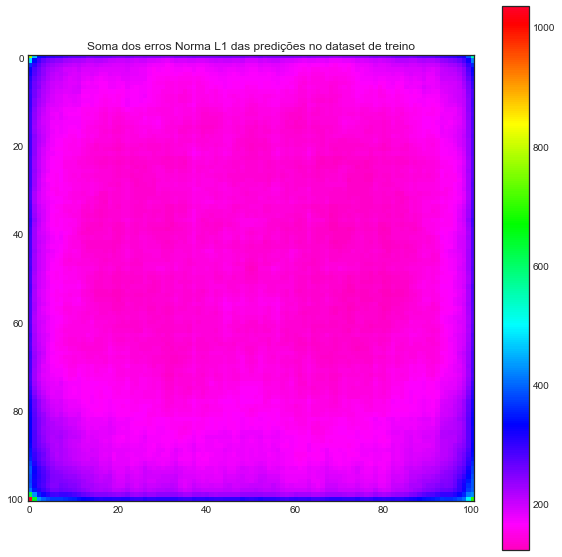

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(difs_cond_train,cmap='gist_rainbow_r')
plt.colorbar()
plt.title('Soma dos erros Norma L1 das predições no dataset de treino')
plt.savefig('ErroL1DatasetTreino.png',bbox_inches='tight')
plt.show()

Note que no centro tivemos uma excelente predição, mas nas bordas não....

#### Dados de Validação/Teste

In [36]:
difs_valid=preds_valid-y_valid

In [37]:
difs_cond_valid=np.zeros((101,101))
for i in range(difs_valid.shape[0]):
    difs_cond_valid+=np.abs(difs_valid[i,:,:])

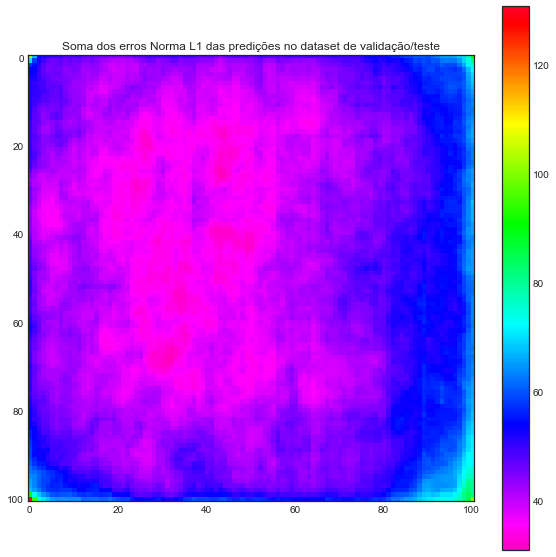

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(difs_cond_valid,cmap='gist_rainbow_r')
plt.colorbar()
plt.title('Soma dos erros Norma L1 das predições no dataset de validação/teste')
plt.savefig('ErroL1DatasetValid.png',bbox_inches='tight')
plt.show()

Assim como nos dados de treino, no centro tivemos uma excelente predição, mas nas bordas não...
Note que os erros estão sempre nas bordas,  mas será que é porque o sal está sempre ocorrendo nas bordas?, Vamos avaliar a ocorrência de sal...

### Mapas de ocorrência de sal

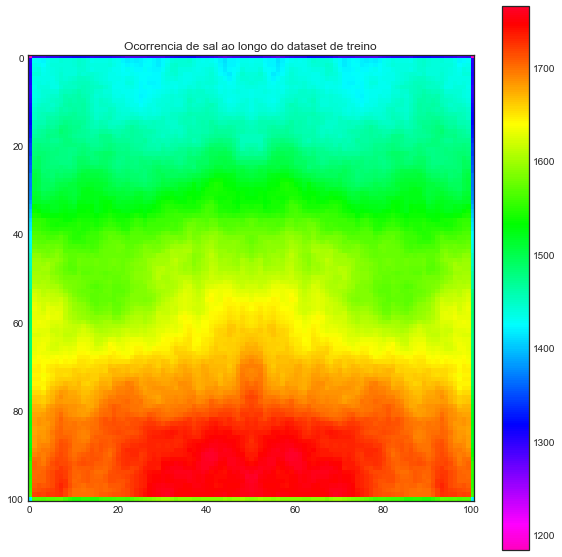

In [39]:
cov_mask_train=np.zeros((101,101))
for i in range(y_train.shape[0]):
    cov_mask_train+=np.abs(y_train[i,:,:])
    
plt.figure(figsize=(10,10))
plt.imshow(cov_mask_train,cmap='gist_rainbow_r')
plt.colorbar()
plt.title('Ocorrencia de sal ao longo do dataset de treino')
plt.savefig('OcorrenciaSalDatasetTreino.png',bbox_inches='tight')
plt.show()

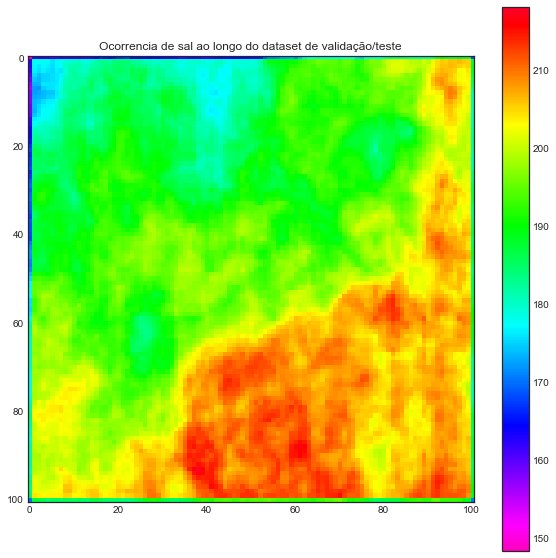

In [40]:
cov_mask_train=np.zeros((101,101))
for i in range(y_valid.shape[0]):
    cov_mask_train+=np.abs(y_valid[i,:,:])
plt.figure(figsize=(10,10))
plt.imshow(cov_mask_train,cmap='gist_rainbow_r')
plt.colorbar()
plt.title('Ocorrencia de sal ao longo do dataset de validação/teste')
plt.savefig('OcorrenciaSalDatasetValid.png',bbox_inches='tight')
plt.show()

# Agora vamos à parte de causalidade do Trabalho

As **Features** candidatas no nosso trabalho são justamente os atributos sísmicos...

Inicialmente vamos gerar os atributos analíticos, para isso utilizaremos a blibioteca scipy

In [47]:
from scipy.signal import hilbert, chirp
import numpy as np
def gera_atributos_analiticos(x):
    # input: uma matriz bidimensional
    # output : As matrizes bidimensionais dos atributos
    envelope=np.zeros(x.shape)
    phase=np.zeros(x.shape)
    freq=np.zeros(x.shape)
    fs=4

    for i in range(x.shape[1]):
        signal=x[:,i]
        analytic_signal = hilbert(signal)
        envelope[:,i] = np.abs(analytic_signal)
        phase[:,i] = np.unwrap(np.angle(analytic_signal))
        freq[:-1,i] = (np.diff(phase[:,i]) /
                           (2.0*np.pi) * fs)
        freq[-1,:]=freq[-2,:]
    return envelope,phase,freq

#### Gerando os atributos analíticos para os dados de treino

In [45]:
train_envelope=np.zeros(x_train.shape)
train_phase=np.zeros(x_train.shape)
train_freq=np.zeros(x_train.shape)

In [48]:
for s in range(x_train.shape[0]):
    train_envelope[s,:,:],train_phase[s,:,:],train_freq[s,:,:] = gera_atributos_analiticos(x_train[s,:,:])

#### Gerando os atributos analíticos para os dados de validação/teste

In [49]:
valid_envelope=np.zeros(x_train.shape)
valid_phase=np.zeros(x_train.shape)
valid_freq=np.zeros(x_train.shape)

In [50]:
for s in range(x_train.shape[0]):
    valid_envelope[s,:,:],valid_phase[s,:,:],valid_freq[s,:,:] = gera_atributos_analiticos(x_train[s,:,:])

#### Agora vamos gerar os atributos de continuidade (coerência/semblance) e variabilidade de amplitudes (desvio padrão)

O primeiro passo é fazer uma fução que atue como uma janela, para isso utilizamos a função scipy.ndimage.generic_filter do scipy. 

In [51]:
import scipy

def moving_window(data, func, window):
  wrapped = lambda x: func(x.reshape(window))
  return scipy.ndimage.generic_filter(data,
                                      wrapped,
                                      window)


#### Vamos gerar agora os dados de coerência. Para isso utilizaremos o algoritmo de gersztenkorn.

In [52]:
def gersztenkorn(region):
  region = region.reshape(-1, region.shape[-1])
  cov = region.dot(region.T)
  vals = np.linalg.eigvalsh(cov)
  return vals.max() / vals.sum()

Gerando a coerência dos dados de treino.

In [ ]:
train_semblance=np.zeros(x_train.shape)
for s in range(x_train.shape[0]):
    train_semblance[s,:,:] = moving_window(x_train[s,:,:],
                               gersztenkorn,
                               (3, 9))

Gerando a coerência dos dados de Validação/Teste.

In [ ]:
valid_semblance=np.zeros(x_valid.shape)
for s in range(x_valid.shape[0])
    train_semblance[s,:,:] = moving_window(x_valid[s,:,:],
                               gersztenkorn,
                               (3, 9))

#### Vamos gerar agora os dados de desvio padrão. Definindo primeiro a função...

In [ ]:
def desvioP(region):
  # Stack traces in 3D region into 2D array
  return np.std(region)

Gerando o Desvio Padrão dos dados de treino.

In [ ]:
train_DesvioP=np.zeros(x_train.shape)
for s in range(x_train.shape[0])
    train_semblance[s,:,:] = moving_window(x_train[s,:,:],
                               desvioP,
                               (3, 9))

Gerando o Desvio Padrão dos dados de Validação/Teste.

In [ ]:
valid_DesvioP=np.zeros(x_valid.shape)
for s in range(x_valid.shape[0])
    train_semblance[s,:,:] = moving_window(x_valid[s,:,:],
                               desvioP,
                               (3, 9))

#### Como vimos que os erros se concentram nas bordas vamos gerar as bordas

In [ ]:
def dist_borda(imagem):
    #input : np.array bidimensional
    #output : np.array bidimensional com as distancias até a borda
    for i in range(imagem.shape[0]):
        for j in range(imagem.shape[1]):
            dist[i,j]=min(
                [i-0,
                 j-0,
                 imagem.shape[0]-i-1,
                 imagem.shape[1]-j-1])
            
    return(dist)

In [ ]:
valid_distBordas=np.zeros(x_valid.shape)
for s in range(x_valid.shape[0])
    valid_distBordas[s,:,:] = dist_borda(imagem[s,:,:])

## Gerando o grafo de causalidade. Para isso utilizaremos a biblioteca causal-learn

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci

Utilizaremos o algoritmo fci. Vamos preparar os dados da forma que o algoritmo recebe.

Vamos utilizar o fci nos dados preditos de validação, para entender o modelo:

In [ ]:
dataset['distborda']=valid_distBordas.reshape(-1)
dataset['ampliude']=x_valid.reshape(-1)
dataset['salt_mask']=preds_valid.reshape(-1)
dataset['salt_mask_error']=difs_valid.reshape(-1)
dataset['envelope']=valid_envelope.reshape(-1)
dataset['frequencia']=valid_freq.reshape(-1)
dataset['fase']=valid_phase.reshape(-1)
dataset['semblance']=valid_semblance.reshape(-1)
dataset['desvioP']=valid_DesvioP.reshape(-1)
df_causal=pd.DataFrame(dataset)
datasetnp=df_causal.to_numpy()

Agora vamos rodar o fci. (SALVAR OS RESULTADOS NUM ARQUIVO SEPARADO)

In [ ]:
G, edges = fci(datasetnp, independence_test_method='kci')

Não conseguimos plotar o grafo de validação. Vamos salvar as arestas em um dicinoário e plotar o grafo manualmente

In [ ]:
df2 = pd.DataFrame(columns=('node1', 'term_node1','term_node2','node2'))
dict1={}
dict2={}
for i in range(len(df_causal.columns)):
    var='X'+str(i+1)
    dict2[var]=df_causal.columns[i]
for i in range(len(edges)):
    dict1['node1']=dict2[edges[i].get_node1().get_name()]
    dict1['node2']=dict2[edges[i].get_node2().get_name()]
    dict1['term_node1']=edges[i].get_endpoint1()
    dict1['term_node2']=edges[i].get_endpoint2()
    df_dict = pd.DataFrame([dict1])
    df2=pd.concat([df2, df_dict], ignore_index=True)

Salvando o grafo final

In [ ]:
df2.to_csv('grafo_causalidade_final.csv')

Carregando o grafo de causalidade final

In [ ]:
df2=pd.read_csv('grafo_causalidade_final.csv')

In [ ]:
df2